🔍 Glass Reflection Detector for Google Colab (Enhanced)
📤 Upload your image with glass reflection...


Saving WhatsApp Image 2025-11-06 at 03.15.02.jpeg to WhatsApp Image 2025-11-06 at 03.15.02 (1).jpeg

✅ Processing: WhatsApp Image 2025-11-06 at 03.15.02 (1).jpeg
🔍 Analyzing image with enhanced detection...


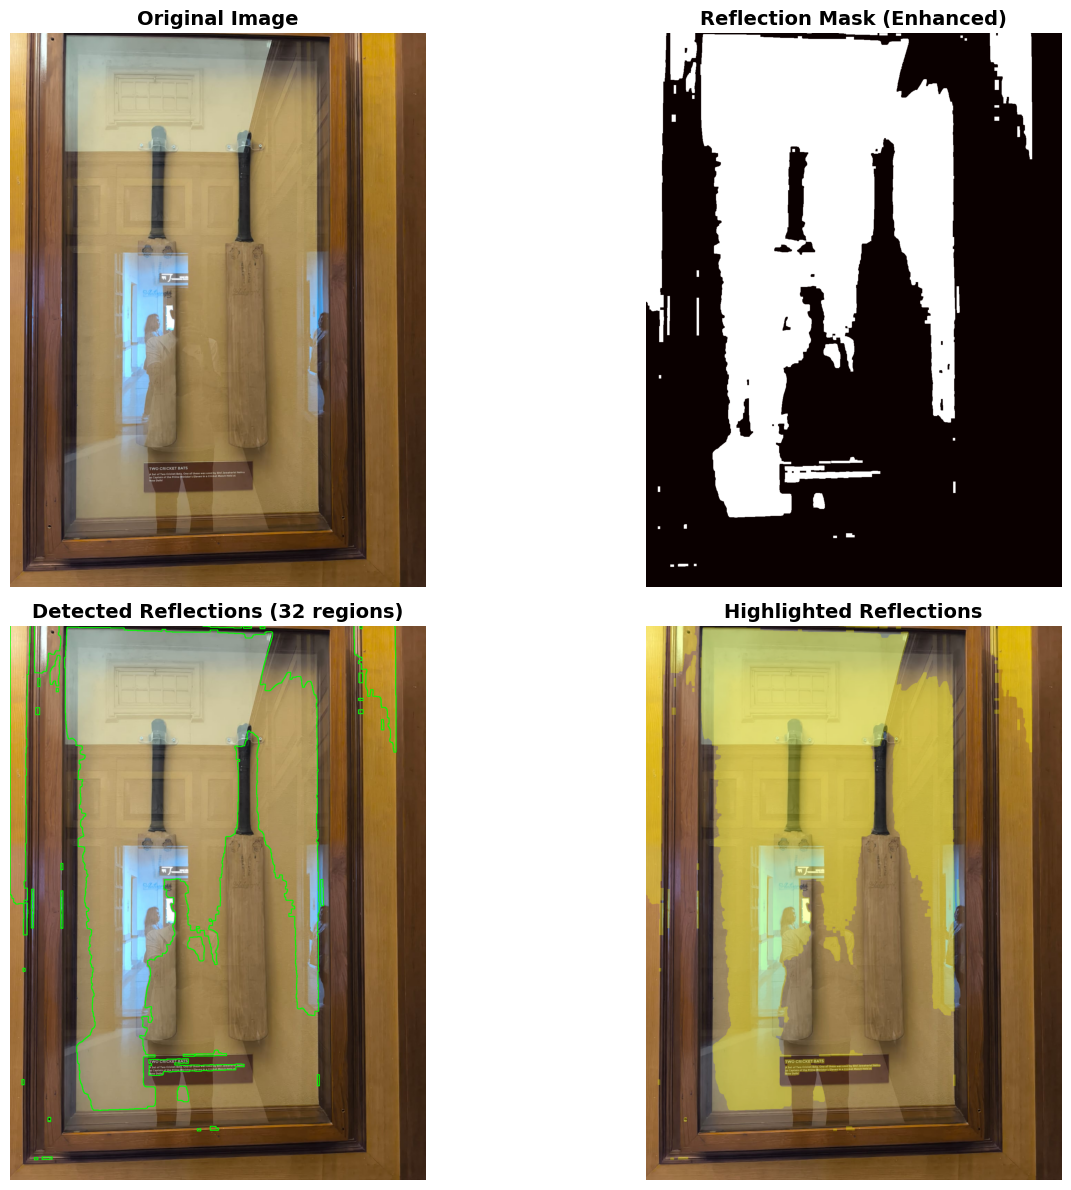


✨ Successfully detected 32 reflection region(s)


In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

def detect_glass_reflection(image):
    if len(image.shape) == 2:
        img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif len(image.shape) == 3:
        if image.shape[2] == 4:
            img = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
        elif image.shape[2] == 3:
            img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        else:
            img = image
    else:
        img = image

    # Convert to different color spaces for analysis
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Apply bilateral filter to reduce noise while preserving edges
    gray_filtered = cv2.bilateralFilter(gray, 9, 75, 75)

    # Method 1: Detect bright regions (LOWERED threshold for more sensitivity)
    _, bright_mask = cv2.threshold(gray_filtered, 140, 255, cv2.THRESH_BINARY)

    # Method 2: Adaptive thresholding for local brightness variations
    adaptive_mask = cv2.adaptiveThreshold(gray_filtered, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 15, -5)

    # Method 3: Detect high luminance in LAB color space
    l_channel = lab[:, :, 0]
    _, luminance_mask = cv2.threshold(l_channel, 160, 255, cv2.THRESH_BINARY)

    # Method 4: Detect specular highlights using Laplacian (LOWERED threshold)
    laplacian = cv2.Laplacian(gray_filtered, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))
    _, specular_mask = cv2.threshold(laplacian, 15, 255, cv2.THRESH_BINARY)

    # Method 5: Gradient magnitude (strong transitions)
    sobelx = cv2.Sobel(gray_filtered, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_filtered, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(sobelx**2 + sobely**2)
    gradient_mag = np.uint8(255 * gradient_mag / np.max(gradient_mag))
    _, gradient_mask = cv2.threshold(gradient_mag, 30, 255, cv2.THRESH_BINARY)

    # Method 6: Detect saturation drops (reflections often desaturate colors)
    saturation = hsv[:, :, 1]
    _, low_sat_mask = cv2.threshold(saturation, 50, 255, cv2.THRESH_BINARY_INV)
    # Combine with brightness
    desaturated_bright = cv2.bitwise_and(low_sat_mask, bright_mask)

    # Combine multiple masks with weighted approach
    # Reflections are bright OR have strong gradients OR are specular
    reflection_mask = cv2.bitwise_or(bright_mask, specular_mask)
    reflection_mask = cv2.bitwise_or(reflection_mask, luminance_mask)
    reflection_mask = cv2.bitwise_or(reflection_mask, desaturated_bright)

    # Add gradient information
    reflection_mask = cv2.bitwise_or(reflection_mask,
                                     cv2.bitwise_and(gradient_mask, bright_mask))

    # Apply morphological operations to clean up and connect nearby regions
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_medium = np.ones((5, 5), np.uint8)
    kernel_large = np.ones((7, 7), np.uint8)

    # Close small gaps
    reflection_mask = cv2.morphologyEx(reflection_mask, cv2.MORPH_CLOSE, kernel_medium, iterations=2)

    # Remove small noise
    reflection_mask = cv2.morphologyEx(reflection_mask, cv2.MORPH_OPEN, kernel_small)

    # Dilate to make reflections more prominent
    reflection_mask = cv2.dilate(reflection_mask, kernel_medium, iterations=1)

    # Find contours of reflection regions
    contours, _ = cv2.findContours(reflection_mask, cv2.RETR_EXTERNAL,
                                     cv2.CHAIN_APPROX_SIMPLE)

    # Create output images
    result = img.copy()
    highlighted = img.copy()

    # Filter contours by area (LOWERED threshold for more detections)
    min_area = 50  # Reduced from 100
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Draw contours on result
    cv2.drawContours(result, valid_contours, -1, (0, 255, 0), 2)

    # Highlight reflection regions
    for cnt in valid_contours:
        mask_single = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask_single, [cnt], -1, 255, -1)
        # Create yellow overlay for reflection regions
        overlay = highlighted.copy()
        overlay[mask_single == 255] = [0, 255, 255]  # Cyan color in BGR
        highlighted = cv2.addWeighted(highlighted, 0.7, overlay, 0.3, 0)

    # Convert BGR to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    highlighted_rgb = cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB)

    return img_rgb, reflection_mask, result_rgb, highlighted_rgb, len(valid_contours)


def visualize_results(img, mask, result, highlighted, num_reflections):
    """Display the detection results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask, cmap='hot')
    axes[0, 1].set_title('Reflection Mask (Enhanced)', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(result)
    axes[1, 0].set_title(f'Detected Reflections ({num_reflections} regions)',
                         fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(highlighted)
    axes[1, 1].set_title('Highlighted Reflections', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def upload_and_detect():
    """Upload image and detect reflections - Colab friendly"""
    print("📤 Upload your image with glass reflection...")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    # Get the first uploaded file
    filename = list(uploaded.keys())[0]
    print(f"\n✅ Processing: {filename}")

    # Read the image
    image_bytes = uploaded[filename]
    image = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image)

    # Detect reflections
    print("🔍 Analyzing image with enhanced detection...")
    img, mask, result, highlighted, num_reflections = detect_glass_reflection(image_np)

    # Visualize
    visualize_results(img, mask, result, highlighted, num_reflections)
    print(f"\n✨ Successfully detected {num_reflections} reflection region(s)")

    if num_reflections == 0:
        print("\n💡 Tip: If no reflections detected, your image might have:")
        print("   - Very subtle reflections")
        print("   - Dark overall lighting")
        print("   - Try adjusting brightness thresholds in the code")


# Run this in Colab
print("🔍 Glass Reflection Detector for Google Colab (Enhanced)")
print("=" * 50)
upload_and_detect()